**PROBLEM STATEMENT**

The data is collected from 10 stores in different cities. The certain attributes of each product and store have been defined.
This data is collected to understand the properties of products and outlets that play a KEY role in increasing sales.

**AIM**: To build a machine learning model to predict the sales of each product at a particular outlet.

**Evaluation Metric** : ROOT MEAN SQUARED ERROR (RMSE)

                                |VARIABLE| DESCRIPTION|
                                -----------------------
                                |ITEM IdentIfier| Unique product ID|

In [1]:
path = "C:/Users/Chigozie/Documents/data science/analyticsvidya_data/bigMartSales"

In [2]:
import os, gc, warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import missingno as msno
import random
import category_encoders as cat_enc

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.compose import ColumnTransformer

In [5]:
#FOR PREPRODUCIBILITY
seed= 42
np.random.seed(seed)

In [6]:
%matplotlib inline
pd.set_option('display.max_columns', 50)
plt.style.use('bmh')

In [7]:
def randomColors(seed=42):
    """
    Random color generator
    :Returns Hex colors
    """
    np.random.RandomState(seed)
    colors = [i for i in range(0,10)]+['A', 'B', 'C', 'D', 'E']
    color= np.random.choice(colors, 6, replace=False)
    return '#'+''.join(color)

In [8]:
train = pd.read_table(path+'/Train.txt', sep=',')
test = pd.read_table(path+'/Test.txt', sep=',')
subfile = pd.read_table(path+'/SampleSubmission.txt', sep=',')

In [59]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Store_Unique_Items,Store_Age,kfold
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,3,Tier 1,Supermarket Type1,3735.1380,9,21,2.0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,3,Tier 3,Supermarket Type2,443.4228,9,11,7.0
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,3,Tier 1,Supermarket Type1,2097.2700,10,21,7.0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,1,Tier 3,Grocery Store,732.3800,9,22,8.0
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,4,Tier 3,Supermarket Type1,994.7052,9,33,9.0


In [10]:
test.head(3)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.30,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.60,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store


In [11]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [12]:
train.Item_Identifier.nunique()

1559

**Filling in missing values**

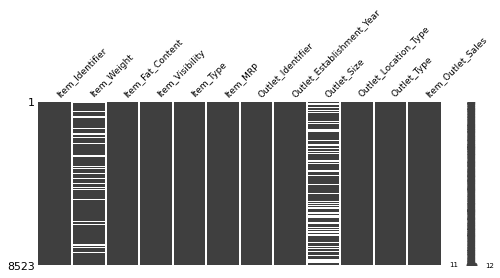

In [13]:
msno.matrix(train, figsize=(8,3), fontsize=9);

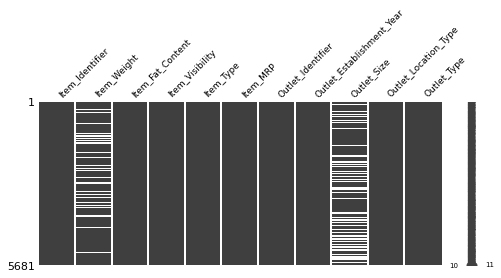

In [14]:
msno.matrix(test, figsize=(8,3), fontsize=9);

**`Item weight` and `outlet_size` are the only features with missing values**

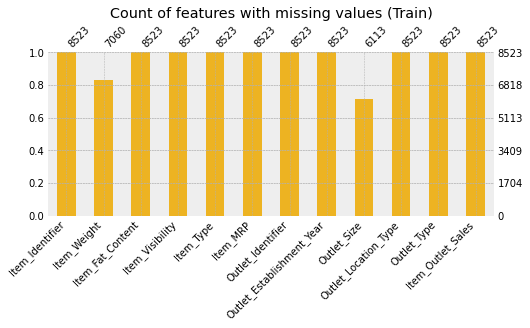

In [15]:
msno.bar(train, figsize=(8,3), fontsize=10, color='#edb322')
plt.title('Count of features with missing values (Train)');

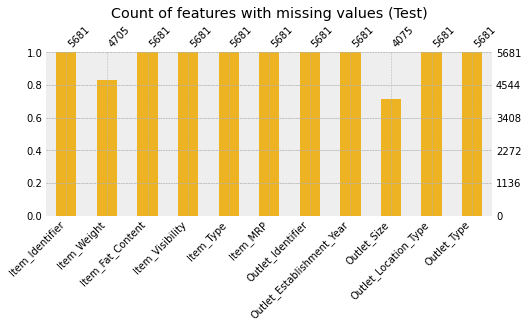

In [16]:
msno.bar(test, figsize=(8,3), fontsize=10, color='#edb322')
plt.title('Count of features with missing values (Test)');

In [17]:
train[train.Item_Weight.isna()].Item_Identifier.value_counts()

FDI22    2
FDY56    2
NCG30    2
FDL20    2
FDT09    2
        ..
FDJ08    1
NCE07    1
DRG03    1
FDA51    1
NCP43    1
Name: Item_Identifier, Length: 1142, dtype: int64

**At least each product has a missing item weight, We will fill these with their mean item weights**

In [18]:
train[train.Outlet_Size.isna()].Outlet_Identifier.unique()

array(['OUT010', 'OUT045', 'OUT017'], dtype=object)

**Three Stores have unknown sizes. So will replace them with "Unknown", signifying missing sizes**

In [19]:
df = train.append(test)[train.columns]

In [20]:
missing_items = df[df.Item_Weight.isna()].Item_Identifier.unique()

In [21]:
mean_item_weights  = df[df.Item_Identifier.isin(missing_items)].groupby('Item_Identifier').Item_Weight.mean().to_dict()

In [22]:
#REPLACING MISSING ITEM WEIGHTS
for items in missing_items:
    train.loc[(train.Item_Identifier == items) & (train.Item_Weight.isna()), 'Item_Weight'] = mean_item_weights[items]
    test.loc[(test.Item_Identifier == items) & (test.Item_Weight.isna()), 'Item_Weight'] = mean_item_weights[items]

In [23]:
#replacing missing Outlet sizes
train.loc[train.Outlet_Size.isna(), 'Outlet_Size'] = 'Unk'
test.loc[test.Outlet_Size.isna(), 'Outlet_Size'] = 'Unk'

**EDA**

****Highest performing Outlets****

Stores with the highest Revenue

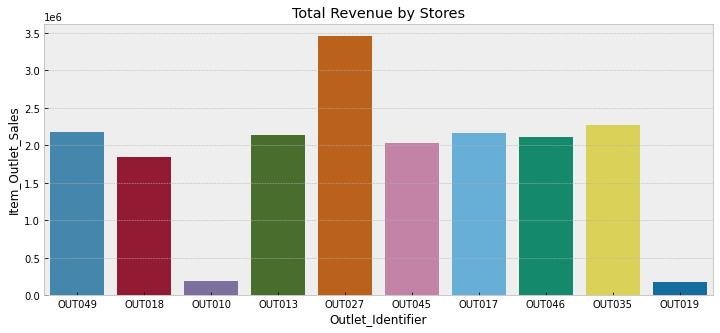

In [24]:
plt.figure(figsize=(12,5))
sns.barplot('Outlet_Identifier', 'Item_Outlet_Sales', data=train, estimator=np.sum, ci=None)
plt.title('Total Revenue by Stores');

**Stores 10 and 19 are the least performing Outlets, while store 27 is the store with the highest revenue**

In [ ]:
sns.boxplot(train.Outlet_Type, train.Item_Outlet_Sales);

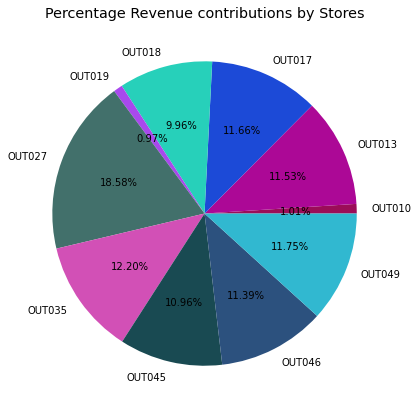

In [25]:
plt.figure(figsize=(12,7))
plt.pie(train.groupby('Outlet_Identifier').Item_Outlet_Sales.sum().transform(lambda x: x/x.sum() * 100),
        autopct='%.2f%%', labels=train.groupby('Outlet_Identifier').Item_Outlet_Sales.sum().index, 
        colors= [randomColors() for i in range(10)])
plt.title('Percentage Revenue contributions by Stores');

**19% of total revenue for big mart stores come from Outlet 27, followed by Outlet 35 with 12%**

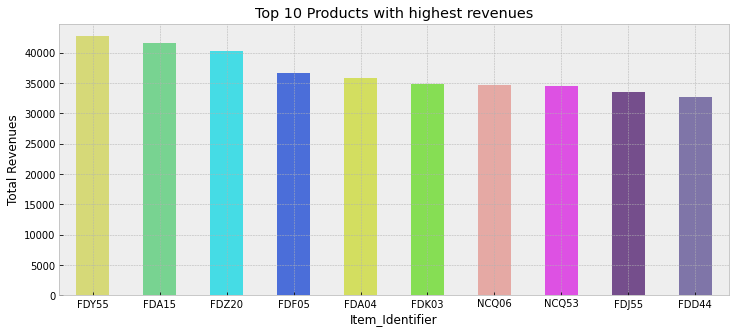

In [26]:
train.groupby('Item_Identifier').Item_Outlet_Sales.sum().sort_values(ascending=False)[:10].plot.bar(
    figsize=(12,5), rot=0, title='Top 10 Products with highest revenues',ylabel='Total Revenues', 
    color=[randomColors() for i in range(10)], alpha=0.75);

In [27]:
df.Item_Fat_Content.unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

Item Fat content contains similar words in different letter characters. We have just 2 categories: If the Item 

In [28]:
def replace_items(x):
    if x in ['low fat', 'LF']: return 'Low Fat'
    elif x in ['reg']: return 'Regular'
    else: return x

In [29]:
#replacing Similar Fat content descriptions
train.Item_Fat_Content = train.Item_Fat_Content.apply(replace_items)
test.Item_Fat_Content = test.Item_Fat_Content.apply(replace_items)

In [30]:
df.Item_Type.unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [31]:
df.Outlet_Type.unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

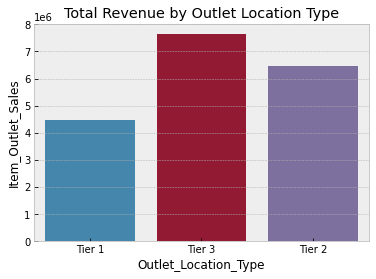

In [32]:
sns.barplot('Outlet_Location_Type', 'Item_Outlet_Sales', data=train, estimator=np.sum, ci=None)
plt.title('Total Revenue by Outlet Location Type');

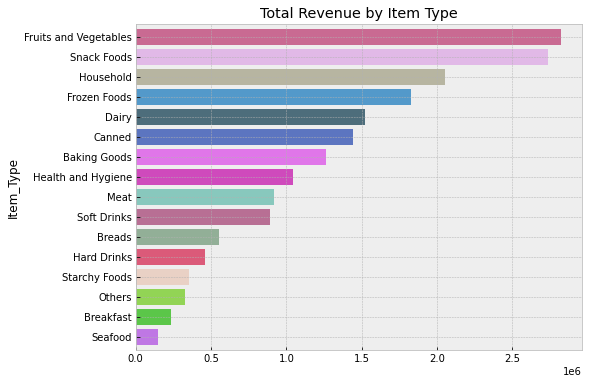

In [33]:
colors = [randomColors() for i in range(16)]
train.groupby('Item_Type').Item_Outlet_Sales.sum().sort_values().plot.barh(
    figsize=(8,6), title='Total Revenue by Item Type', color=colors, alpha=0.7, width=0.8);

**Item Type with the highest revenue is Fruits and Vegetables followed by Snacks and Food**

Lets see the number of products that make up each category

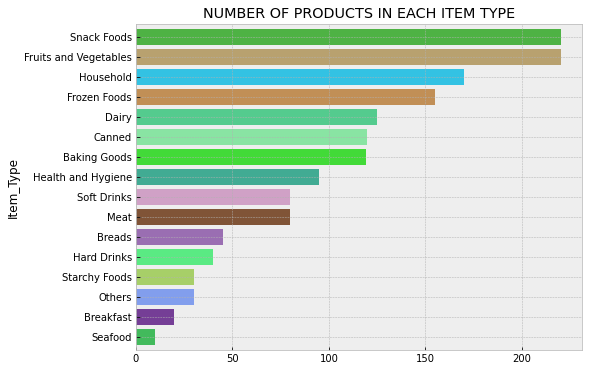

In [34]:
train.groupby(['Item_Type']).Item_Identifier.nunique().sort_values().plot.barh(
    figsize=(8,6), title='NUMBER OF PRODUCTS IN EACH ITEM TYPE', 
    color=[randomColors() for i in range(16)], width=0.8, alpha=0.8);

**Big Mart stores sell more of Snack foods and Fruits and Vegetables, followed Household Products and Frozen foods**

**Numerical Features**

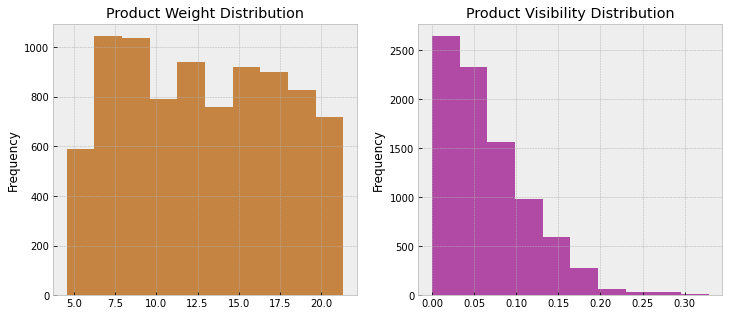

In [35]:
plt.figure(figsize=(12,5))
plt.subplot(121)
train.Item_Weight.plot.hist(title='Product Weight Distribution', color=randomColors(), alpha=0.75)
plt.subplot(122)
train.Item_Visibility.plot.hist(title= 'Product Visibility Distribution', color=randomColors(),alpha=0.75);

1. `Most products weigh b/w 6 and 10.`
2. `Most of the Products are small in size (from the distribution of the Item visibility)`

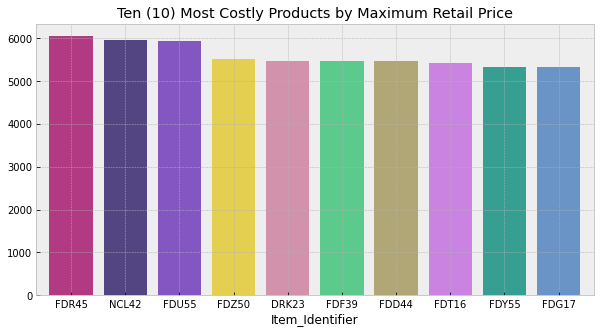

In [36]:
train.groupby('Item_Identifier').Item_Outlet_Sales.mean().sort_values(ascending=False)[:10].plot.bar(
    figsize=(10,5),rot=0, title='Ten (10) Most Costly Products by Maximum Retail Price', width=0.8,
    color=[randomColors() for i in range(10)], alpha=0.8);

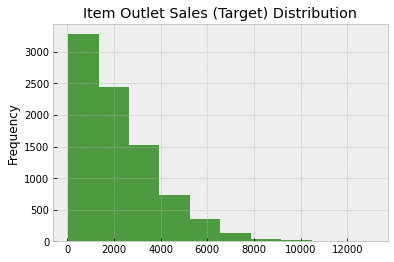

In [37]:
train.Item_Outlet_Sales.plot.hist(color=randomColors(), title='Item Outlet Sales (Target) Distribution', alpha=0.8);

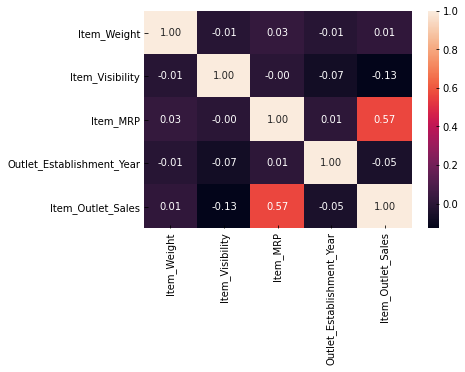

In [38]:
sns.heatmap(train.select_dtypes('number').corr(), annot=True, fmt='.2f');

1. **`THERE'S A WEAK POSITIVE RELATIONSHIP BTW THE MAXIMUM RETAIL PRICE OF A PRODUCT TO THE PRICE OF THAT PRODCUT IN AN OUTLET`**
<p><P>

2. **`THERE'S A WEAK NEGATIVE RELATIONSHIP BTW THE ITEM VISIBILITY AND THE PRICE OF A PRODUCT SOLD IN AN OUTLET (ie. THE SMALLER THE AREA OF DISPLAY OF A PRODUCT THE PRICE OF THAT PRODUCT SEEM TO INCREASE WEAKLY. 
THIS MAKES SENSE, BECAUSE THE DISPLAY AREA WILL CONTAIN MORE OF THE PRODUCT -MORE AVAILABILITY OF THE PRODUCT- AND IF THAT PRODUCT IS THE MOST PURCHASED, THE MORE THE REVENUE GENERATED FROM THAT PRODUCT)`**


### Feature Engineering

1. `The Number of unique products sold in a particular store may affect the price of that product`

In [39]:
df = train.append(test)[train.columns]

In [40]:
df['Store_Unique_Items'] = df.groupby(['Item_Identifier']).Outlet_Identifier.transform('nunique')
df['Store_Age'] = 2020 - df.Outlet_Establishment_Year

In [41]:
#replacing Outlet sizes
df.replace({'Unk' : 1, 'Small' : 2, 'Medium' : 3, 'High' : 4}, inplace=True)

In [42]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [43]:
train = df[df.Item_Outlet_Sales.notna()]
test = df[df.Item_Outlet_Sales.isna()].drop('Item_Outlet_Sales', 1)

In [58]:
train.to_csv(path+'/Train_cleaned.csv', index=False)
test.to_csv(path+'/Test_cleaned.csv', index=False)

**Modeling**

In [44]:
scaler = StandardScaler()

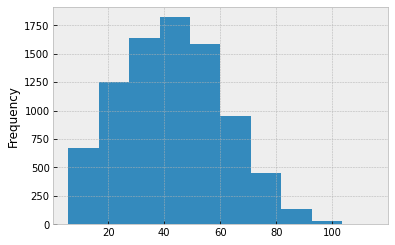

In [45]:
np.sqrt(train.Item_Outlet_Sales).plot.hist();

In [46]:
cat_cols = ['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier','Outlet_Location_Type','Outlet_Type']

In [60]:
def train_model(model, df, test_df, n_folds=7):
    """
    Function for Training Model
    :params model: Instantiated model
    :params df: Train data
    :params test_df: Test_data
    :returns test_predictions
    """
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    for fold, (tr_idx, val_idx) in enumerate(kfold.split(
        df.drop('Item_Outlet_Sales', 1), df.Item_Outlet_Sales)):
        df.loc[val_idx, 'kfold'] = fold
    
    #ONE HOT ENCODING
#     df = pd.get_dummies(df, columns=['Item_Fat_Content', 'Outlet_Location_Type', 
#                                      'Outlet_Type'], drop_first=False)
#     test_df = pd.get_dummies(test_df, columns=['Item_Fat_Content', 'Outlet_Location_Type', 
#                                                'Outlet_Type'], drop_first=False)
    
    #Mean encoder
    encoder = cat_enc.TargetEncoder(cols = cat_cols, smoothing=100)
    features =  [col for col in df.columns if col not in ['Item_Outlet_Sales', 'kfold']]
    
    tr_avg, val_avg = 0, 0
    test_preds= []
    
    for fold_ in range(n_folds):
        
        train_df = df[df.kfold != fold_]
        val_df = df[df.kfold == fold_]
        
        xtrain, ytrain = train_df[features], np.log(train_df.Item_Outlet_Sales)
        xval, yval = val_df[features], np.log(val_df.Item_Outlet_Sales)
        
        #Mean encoding categrical columns
        xtrain = encoder.fit_transform(xtrain, ytrain)
        xval = encoder.transform(xval)
        
        xtest = encoder.transform(test_df[features]) #mean encoding test_data
        
        #scaling
        scale_cols = ['Outlet_Establishment_Year']
        columntrans = ColumnTransformer([('transform', scaler, scale_cols)], remainder='passthrough', n_jobs=-1)
        
        xtrain_sc= columntrans.fit_transform(xtrain)
        xval_sc = columntrans.transform(xval)
        xtest_sc = columntrans.transform(xtest)
        
        #fitting
        model.fit(xtrain_sc, ytrain)
        preds = model.predict(xval_sc)
        val_rmse = mean_squared_error(np.exp(yval), np.exp(preds), squared=False) #Squaring both actual and predictions
        tr_rmse = mean_squared_error(np.exp(ytrain), np.exp(model.predict(xtrain_sc)), squared=False)
        
        tr_avg += tr_rmse
        val_avg += val_rmse
        
        #predicting Test set
        test_pred = np.exp(model.predict(xtest_sc))
        test_preds.append(test_pred)
        
        print(f'Fold {fold_+1}\tTrain RMSE: {tr_rmse.round(4)}, Val RMSE: {val_rmse.round(4)}')
    print(f'AVG Train RMSE: {(tr_avg/(n_folds)).round(4)}, AVG Val RMSE: {(val_avg/n_folds).round(4)}')
    print()
    return np.mean(test_preds, 0).astype('float32')

In [48]:
ridge = Ridge(random_state=seed, alpha= 500)

In [61]:
ridge_pred = train_model(ridge, train, test, 10)

Fold 1	Train RMSE: 1096.826, Val RMSE: 1108.056
Fold 2	Train RMSE: 1096.186, Val RMSE: 1094.8792
Fold 3	Train RMSE: 1089.883, Val RMSE: 1174.4766
Fold 4	Train RMSE: 1099.8893, Val RMSE: 1105.8121
Fold 5	Train RMSE: 1093.6914, Val RMSE: 1108.8626
Fold 6	Train RMSE: 1093.585, Val RMSE: 1134.4558
Fold 7	Train RMSE: 1079.8551, Val RMSE: 1256.9615
Fold 8	Train RMSE: 1097.509, Val RMSE: 1123.3551
Fold 9	Train RMSE: 1088.6474, Val RMSE: 1180.1383
Fold 10	Train RMSE: 1081.6992, Val RMSE: 1216.8138
AVG Train RMSE: 1091.7771, AVG Val RMSE: 1150.3811


In [50]:
features = train.columns.drop(['kfold', 'Item_Outlet_Sales'])

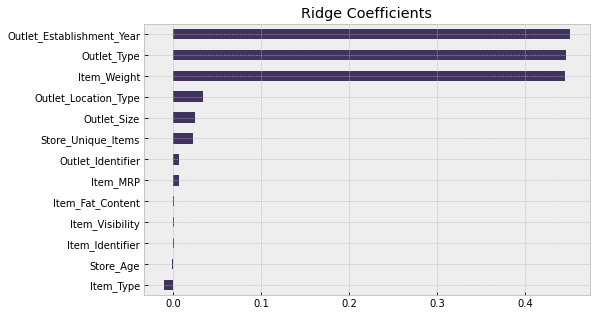

In [51]:
pd.Series(ridge.coef_, index=features).sort_values().plot.barh(
    figsize=(8,5),title='Ridge Coefficients', color=randomColors(), alpha=0.8);

**SUBMISSION**

In [62]:
ridge_df = subfile.copy()
ridge_df.Item_Outlet_Sales = ridge_pred

In [63]:
ridge_df.to_csv(path+'/predictions/ridge_bl.csv', index=False)

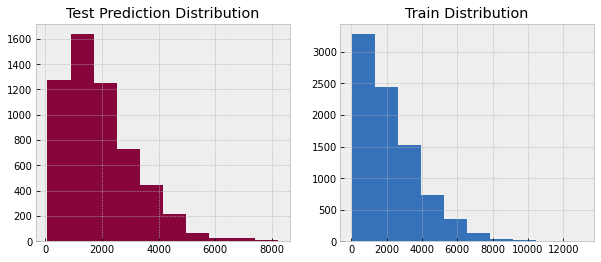

In [54]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(ridge_df.Item_Outlet_Sales, color=randomColors())
plt.title('Test Prediction Distribution')
plt.subplot(122)
plt.hist(train.Item_Outlet_Sales, color=randomColors())
plt.title('Train Distribution');

In [65]:
gc.collect()

20